Alaska Airlines

In [124]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.figure
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

## Preprocessing

In [141]:
df = pd.read_csv('flight_data_SAN.csv')
df.head()

,airline,flightno,origin,dest,totalseatcount,generalacft,depgate,arrgate,scheduled_departure_dttm,scheduled_arrival_dttm,actual_departure_dttm,actual_arrival_dttm,airtime,taxiout,taxiin,depvariance,arrvariance,internationalflag
0,AC,1886,SAN,YYZ,174,32S,034,F36,2018-01-01 11:40:00,2018-01-01 19:11:00,2018-01-01 13:03:00,2018-01-01 21:14:00,251.0,34.0,26.0,83.0,123.0,1
1,WN,6418,SAN,TUS,143,737,8,A3,2018-01-01 21:55:00,2018-01-02 00:10:00,2018-01-01 22:30:00,2018-01-02 00:36:00,50.0,12.0,4.0,35.0,26.0,0
2,AS,3456,SAN,STL,76,EMJ,18,C15,2018-01-01 09:40:00,2018-01-01 15:02:00,2018-01-01 09:37:00,2018-01-01 15:04:00,189.0,14.0,4.0,-3.0,2.0,0
3,WN,552,SAN,SMF,143,737,8,B15,2018-01-01 19:10:00,2018-01-01 20:45:00,2018-01-01 19:53:00,2018-01-01 21:19:00,67.0,15.0,4.0,43.0,34.0,0
4,WN,983,SAN,SMF,143,737,1A,B17,2018-01-01 15:05:00,2018-01-01 16:40:00,2018-01-01 15:15:00,2018-01-01 16:43:00,70.0,14.0,4.0,10.0,3.0,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188525 entries, 0 to 188524
Data columns (total 18 columns):
airline                     188525 non-null object
flightno                    188525 non-null int64
origin                      188525 non-null object
dest                        188525 non-null object
totalseatcount              188525 non-null int64
generalacft                 188363 non-null object
depgate                     185087 non-null object
arrgate                     182204 non-null object
scheduled_departure_dttm    188525 non-null object
scheduled_arrival_dttm      188525 non-null object
actual_departure_dttm       188212 non-null object
actual_arrival_dttm         188125 non-null object
airtime                     187259 non-null float64
taxiout                     187413 non-null float64
taxiin                      186931 non-null float64
depvariance                 188212 non-null float64
arrvariance                 188116 non-null float64
internationalflag  

In [142]:
#Dropped columns:  Information after wheels up and unessary 
df.drop(columns=['arrvariance', 'arrgate','arrvariance', 'scheduled_arrival_dttm', 'actual_arrival_dttm',
                 'taxiin', 'airtime','origin','depvariance'], inplace=True)

In [143]:
#Changing data type of departure and arrival times from object to datetime
df['actual_departure_dttm'] = [pd.to_datetime(x) for x in df['actual_departure_dttm']]
df['scheduled_departure_dttm'] = [pd.to_datetime(x) for x in df['scheduled_departure_dttm']]

In [144]:
#We are going to use gate as a proxy for distance to runway. Need them as numbers 
df['depgate'].unique()

array(['034', '8', '18', '1A', '5', '17', '46', '15', '10', '11', '9',
       '42', '44', '41', '3', '49', '14', '7', '25', '23', '2', '47',
       '16', '4', '45', '32', '40', '38', '35', '28', '43', '39', '24',
       '33', '13', '51', '37', '1', '26', '36', '31', nan, '30', '27',
       '12', '6', '29', '34', '22', '50', '48', '036', '041', '043',
       '1286', 'Gate 18', 'Gate 15', 'Gate 16', 'Gate 11', 'Gate 13',
       'Gate 14', 'Gate 17', 'Gate 12', 'H30', '20', '21', '037', '16B',
       'C25', 'E18', 'B12', 'C2', 'A1', 'B4', 'C42', '11B', 'C4', 'B7',
       'C44', 'C3', 'B5', 'C11', 'A14', '2661', '038', '050', '76', '033',
       '956'], dtype=object)

In [145]:
#We need to get rid of any gate not between 1 and 51.  1A --> 0.1, Gate x --> x
df.replace('1A', 0.1,inplace=True)
df.replace("Gate 11", 11,inplace=True)
df.replace("Gate 12", 12,inplace=True)
df.replace("Gate 13", 13,inplace=True)
df.replace("Gate 14", 14,inplace=True)
df.replace("Gate 15", 15,inplace=True)
df.replace("Gate 16", 16,inplace=True)
df.replace("Gate 17", 17,inplace=True)
df.replace("Gate 18", 18,inplace=True)
df = df[~df['depgate'].isin (['1286','H30','16B', 'C25', 'E18', 'B12', 'C2', 'A1', 'B4','C42', '11B', 'C4', 'B7', 'C44', 'C3', 'B5', 'C11', 'A14', '2661', '76', '956'])]
df['depgate'] = pd.to_numeric(df['depgate'])

In [146]:
#Exploratory analysis in Tableau showed a taxiout value of 1039 (and also has a negative airtime) so we remove it
df = df[df['taxiout'] != 1039]

In [147]:
df.dropna(inplace=True)

In [12]:
df.shape

(183328, 10)

In [446]:
183328/188525

0.972433364275295

In [14]:
df.to_csv('alaska_cleaned.csv')

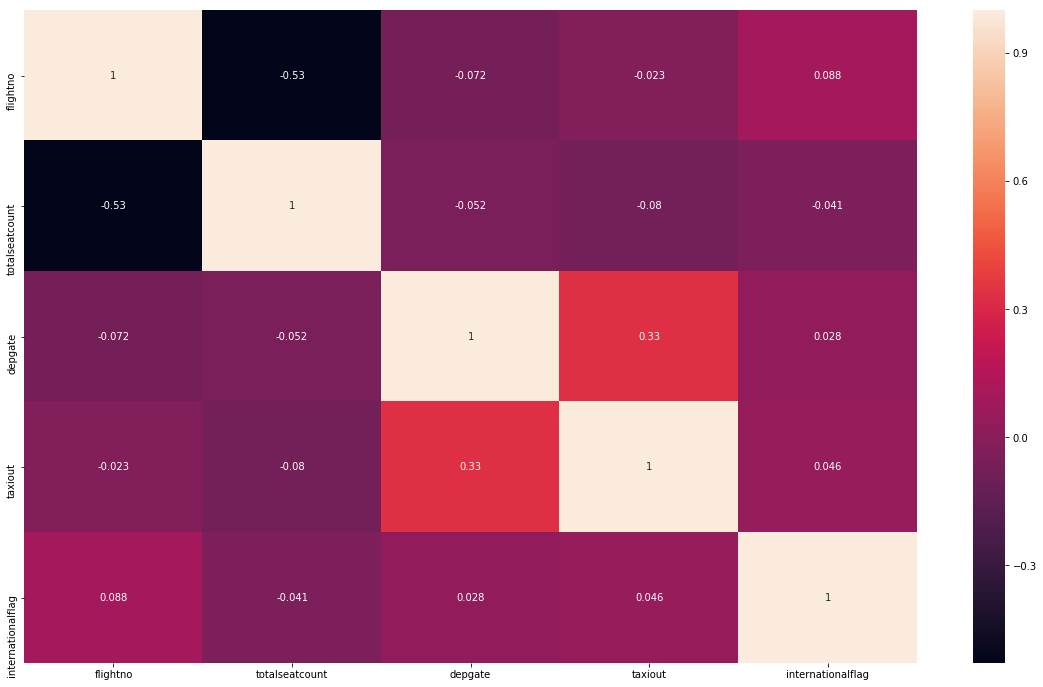

In [115]:
plt.figure(figsize=[20,12])
sns.heatmap(df.corr(), annot=True);

## Feature Selection

Research (https://www.aviationsystemsdivision.arc.nasa.gov/publications/2015/AIAA-2015-2272.pdf, 
https://pdfs.semanticscholar.org/cdcb/8f9380999147e162fbb4a67b9cfc889e8bc4.pdf)
has shown the following features should be considered: Gate, Spot, Runway, Aircraft model, Taxi distance from gate to runway, Number of departures on the surface by runway, and Number of arrivals on the surface by terminal.
We only have one runway (95% of the time) and we do not know the number of arrivals.
I will add in month, time of day, day of week as a proxy for spot/congestion


In [148]:
#Need to separate off month, day of week, and time of day from scheduled depart time
#Monday is 0 and Sunday is 6
df['year'] = df['scheduled_departure_dttm'].dt.year
#df['month'] = df['scheduled_departure_dttm'].dt.month
df['hour'] = df['scheduled_departure_dttm'].dt.hour
#df['dow'] = df['scheduled_departure_dttm'].dt.weekday

In [149]:
#2018 was quite different regarding flights so it was selected for prediction
df = df[df['year']==2018]

In [150]:
df.head()

,airline,flightno,dest,totalseatcount,generalacft,depgate,scheduled_departure_dttm,actual_departure_dttm,taxiout,internationalflag,year,hour
0,AC,1886,YYZ,174,32S,34.0,2018-01-01 11:40:00,2018-01-01 13:03:00,34.0,1,2018,11
1,WN,6418,TUS,143,737,8.0,2018-01-01 21:55:00,2018-01-01 22:30:00,12.0,0,2018,21
2,AS,3456,STL,76,EMJ,18.0,2018-01-01 09:40:00,2018-01-01 09:37:00,14.0,0,2018,9
3,WN,552,SMF,143,737,8.0,2018-01-01 19:10:00,2018-01-01 19:53:00,15.0,0,2018,19
4,WN,983,SMF,143,737,0.1,2018-01-01 15:05:00,2018-01-01 15:15:00,14.0,0,2018,15


In [167]:
dfm = df.drop(columns=['year','airline','generalacft','dest','actual_departure_dttm','scheduled_departure_dttm','flightno'])      

In [168]:
dfm.head()

,totalseatcount,depgate,taxiout,internationalflag,hour
0,174,34.0,34.0,1,11
1,143,8.0,12.0,0,21
2,76,18.0,14.0,0,9
3,143,8.0,15.0,0,19
4,143,0.1,14.0,0,15


In [169]:
dfm['hr6'] = np.where(dfm['hour']== 6, 1, 0)
dfm = dfm.drop(columns=['hour'])

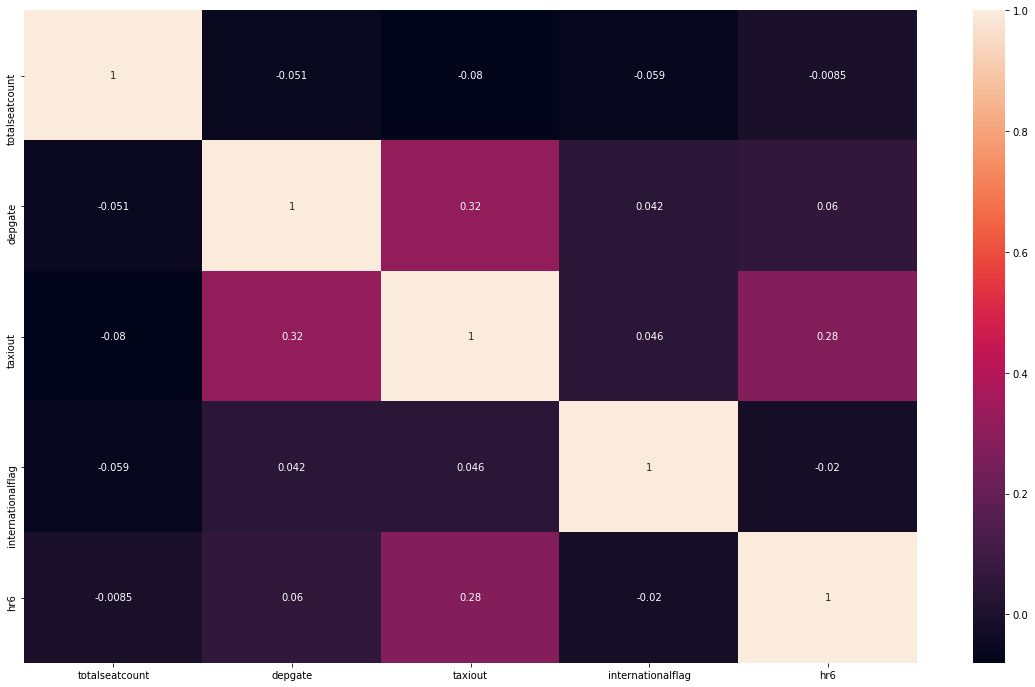

In [170]:
plt.figure(figsize=[20,12])
sns.heatmap(dfm.corr(), annot=True);

In [172]:
dfm = dfm.drop(columns=['internationalflag','totalseatcount'])
dfm.head()

,depgate,taxiout,hr6
0,34.0,34.0,0
1,8.0,12.0,0
2,18.0,14.0,0
3,8.0,15.0,0
4,0.1,14.0,0


In [165]:
dfm.to_csv('alaska_2feature.csv')

## Modeling

In [23]:
df = pd.DataFrame(dfm)

In [24]:
df.head()

,depgate,taxiout,hr6
0,34.0,34.0,0
1,8.0,12.0,0
2,18.0,14.0,0
3,8.0,15.0,0
4,0.1,14.0,0


In [25]:
df.shape

(95447, 3)

In [39]:
#One feature input (gate)
dfin = df.drop(columns= ['taxiout','hr6'] )
dfout = df['taxiout']

#Two feature input (gate and 6am/not 6am)
dfin2 = df.drop(columns= ['taxiout'] )
dfout2 = df['taxiout']

In [43]:
#One feature
X = pd.DataFrame(dfin)
y = pd.DataFrame(dfout)

#Two features
X2 = pd.DataFrame(dfin2)
y2 = pd.DataFrame(dfout2)

In [44]:
print(X.head())
print(X2.head())

   depgate
0     34.0
1      8.0
2     18.0
3      8.0
4      0.1
   depgate  hr6
0     34.0    0
1      8.0    0
2     18.0    0
3      8.0    0
4      0.1    0


In [46]:
X.shape, y.shape, X2.shape, y2.shape

((95447, 1), (95447, 1), (95447, 2), (95447, 1))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,test_size = .2, random_state=42)

In [48]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape, X2_test.shape, y2_test.shape, X2_train.shape, y2_train.shape

((19090, 1),
 (19090, 1),
 (76357, 1),
 (76357, 1),
 (19090, 2),
 (19090, 1),
 (76357, 2),
 (76357, 1))

### Basic random forest

#### One feature

In [51]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
print(randomforest.score(X_train, y_train))
print(mean_squared_error(y_test, randomforest.predict(X_test)))

0.15254225571954494
44.985065468652365


#### Two features

In [70]:
randomforest = RandomForestRegressor()
randomforest.fit(X2_train, y2_train)
print(randomforest.score(X2_train, y2_train))
print(mean_squared_error(y2_test, randomforest.predict(X2_test)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.22345144420505314
42.084500160174855


### Optimized random forest

#### One feature

In [56]:
# Perform Grid-Search
gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid={'max_depth': range(3,7), 'n_estimators': (10, 50, 100, 1000),  },
cv=5, verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
rfr.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

In [62]:
print(rfr.score(X_train, y_train))
print(mean_squared_error(y_test, rfr.predict(X_test)))

0.14871377912339334
45.113960221071


#### Two features

In [67]:
# Perform Grid-Search
gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid={'max_depth': range(3,7), 'n_estimators': (10, 50, 100, 1000),  },
cv=5, verbose=0, n_jobs=-1)

grid_result = gsc.fit(X2_train, y2_train)
best_params = grid_result.best_params_

rfr2 = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
rfr2.fit(X2_train, y2_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

In [73]:
print(rfr2.score(X2_train, y2_train))
print(mean_squared_error(y2_test, rfr2.predict(X2_test)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.21778645956497755
42.19228317980326


### Linear Regression

#### One feature

In [74]:
#No polynomials, logs, etc.
lr = LinearRegression()
lr.fit(X_train, y_train)
print (lr.score(X_train, y_train))
print(mean_squared_error(y_test, lr.predict(X_test)))

0.10237286247984456
47.33756918241079


#### Two features

In [76]:
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
print (lr2.score(X2_train, y2_train))
print(mean_squared_error(y2_test, lr2.predict(X2_test)))

0.17443754491134966
44.28771367518525


The following is a way to determine what is the maximum polynomial to use for linear regression.

#### One feature

The degree 9 had an MSE of: 43.405142899646826


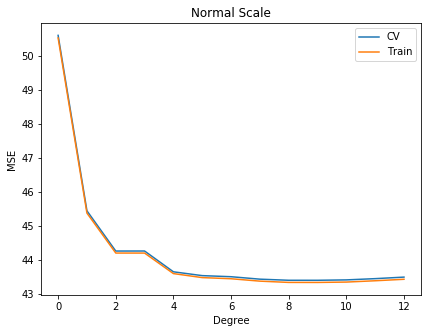

In [82]:
model = LinearRegression()
res_cv = {}
r2_cv = {}
res_train = {}
for degree in range(13):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X)
    
    # calculates the MSE for CV
    scores = cross_val_score(model, X1, y, cv=10, scoring='neg_mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set    
    model.fit(X1,y)
    y_pred = model.predict(X1)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)
    
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())
r2_cv = list(r2_cv.values())


plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])


loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

In [539]:
# Adding degree 9 polynomial to Linear Regression
degree=9
est = make_pipeline(PolynomialFeatures(degree), StandardScaler(),LinearRegression())
est.fit(X_train, y_train)
print(est.score(X_train, y_train))
print(mean_squared_error(y_test, est.predict(X_test)))

0.14315353599875524
45.31490034864096


#### Two features

The degree 8 had an MSE of: 40.04606088050497


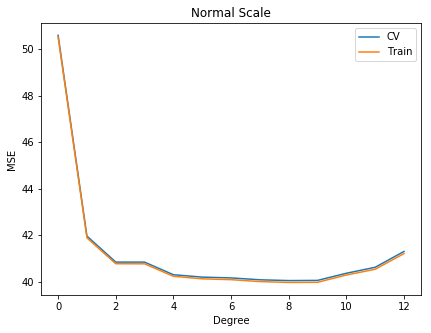

In [99]:
model = LinearRegression()
res_cv = {}
r2_cv = {}
res_train = {}
for degree in range(13):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X2)
    
    # calculates the MSE for CV
    scores = cross_val_score(model, X1, y2, cv=10, scoring='neg_mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set    
    model.fit(X1,y2)
    y_pred = model.predict(X1)
    res_train[degree] = np.sum((y_pred - y2)**2)/len(y2)
    
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())
r2_cv = list(r2_cv.values())


plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])


loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

In [102]:
# Adding degree 8 polynomial to Linear Regression
degree=8
est2 = make_pipeline(PolynomialFeatures(degree), StandardScaler(),LinearRegression())
est2.fit(X2_train, y2_train)
print(est2.score(X2_train, y2_train))
print(mean_squared_error(y2_test, est2.predict(X2_test)))

0.2128373084898907
42.38391747135461


In [103]:
# Adding degree 9 polynomial to Linear Regression
degree=9
est2 = make_pipeline(PolynomialFeatures(degree), StandardScaler(),LinearRegression())
est2.fit(X2_train, y2_train)
print(est2.score(X2_train, y2_train))
print(mean_squared_error(y2_test, est2.predict(X2_test)))

0.21295856970750793
42.370132259015875
